# Table Of Contents

1) Introduction

2) Business Problem

3) Data Understanding 

4) Data Exploration and Analysis

5) Classification Modeling
   - 5a Modeling with seasonality amd analysis
   - 5b Modeling without seasonality* and analysis
   - 5c Modeling weekly trends
   
6) Time series modeling and forecasting

7) Further Considerations with species analysis

8) Conclusion

9) References


# 1) Introduction and Business Understanding 
Allergies are a impact lives  everywhere, but esepcially in Texas, US. Central texas is notorious for severe allergies, but in reality this problem affects the whole state. The surprising thing about this is that most of texas is a desert without much flora to speak of. Houston, however is uniquly positioned in texas being relatively near the desert, the ocean, marshland and forest. 

Allergy seasons occur with consistent regularity throughout the year. Spring and fall are universally known as the worst times of the year for allergies due to high pollen counts. It therefore stands to reason that using basic climate data, like wind speed, temperature and precipitation, seasonal in nature themselves, could be used to estimate and forecast pollen counts

Yet, while very possible, using weather and climate data to predict pollen counts is not particularly ground-breaking, because this data is also subject seasonal fluctuation. However, if seasonality is removed from the equation, does information such as local precipitation, temperature and wind speed still have an effect? 

For many, the a



# Business Problem
The past 2 years, ravaged by the Covid-19 global pandemic, has made much of the world wary of the tiniest sniffle for fear they have contracted the highly infectious disease that has killed so many. Additionally the broad variety and severity of symptoms across the board has had many confuse their sympotons with allergies and vice versa, thus bringing a much greater attention to Allergies in general. 

As the public struggles
when healthcare systems can expect more people due to allergies

# Data Understanding and Preparation

The data used in this report comes from two sources: 
- Pollen data comes from The <a href="https://www.houstontx.gov/health/Pollen-Mold/pollen-archives.html">Houston Health Department website</a>
- Climate data comes from the the <a href="ncei.noaa.gov"> National Oceanic and Atmospheric Administration's (NOAA) National Center for Environmental Information (NCEI) </a>

Pollen Data was compiled from individual monthly spreadsheets from 2013 to 2022 consisting of pollen counts measured in parts per cubic meter. It consists of species specific daily pollen counts collected throughout the month except on weekends and holidays. It also distinguishes between tree, grass and weed pollen. The data was collected by three different technicians. 

Climate data was obtained for three testing sites, 2 located in Houston (suffixed '18' and '60'), and one located in Shreveport, LA (suffixed S), roughly 200 miles away in a highly vegetated area in order to see if its climate has an impact on the airborne pollen levels in Houston. Climate data consists of daily precipitation `PRCP`, average temperature `TAVG` and average wind speed `AWND`. For Shreveport, fastest 2 minute wind speed `WFD2` was also included in an attempt to see if wind currents from the nearby city had any role in Houston's pollen problem. 

Pollen counts were weighted differently for grass, weed, and tree problem based off of their differing classifications for severity levels as explained by the <a href ="https://www.houstontx.gov/health/Pollen-Mold/numbers.html"> Houston Health Department </a>

these adjusted counts were then tallied into one variable, `pollen_weighted`, which itself was used to create 3 distinct classification for daily pollen intensity: `high`, `very_high` and `super_high`

3,372 days in total, just shy of 10 years comprise this time series data. 

The details of this data cleaning and preparation can be found <a href="www.google.com"> here in another notebook in this repo</a>

# Data Exploration
the bulk of preliminary data exploration can be found <a href='www.google.com'> here in a separate notebook.</a> Below shows the highlights as well as the most pertinent findings for this report. 

For the purpose of modeling the individual species will be ignored for now and explored in "Further Considerations" Towards the end of the report.

In [456]:
# python modules to be used in exploration and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

import itertools

%matplotlib inline

In [35]:
#opening the dataframe that was prepared in separate "Data Prep" notebook in this repo (see above for link)
master_df = pd.read_csv('data/master_df.csv')

inspecting the data, there are a number of columns:

In [36]:
master_df.columns

Index(['Alder', 'Ash', 'Ashe Juniper / Bald Cypress', 'Black Gum ',
       'Black Walnut', 'Bushes', 'Birch', 'Cedar', 'Cotton Wood', 'Dogwood',
       'Elm', 'Glandular Mesquite', ' Hackberry', 'Hickory', 'Mulberry',
       'Maple', 'Osage Orange', 'Oak', 'Sycamore', 'Pine', 'Privet',
       'Sweet Gum', 'Gingko Biloba', 'Magnolia', 'Willow', 'Tree Total',
       'Grass Total', 'Tree & Grass Total', 'Amaranth', 'Burweed / Marshelder',
       'Cattail', 'Dog Fennel', 'Lamb's Quarters', 'Nettle', 'Partridge Pea',
       'Pigweed', 'Plum Grannet', 'Ragweed', 'Rumex', 'Sagebrush', 'Saltbrush',
       'Sedge', 'Sneezeweed', 'Other Weed', 'Weed Total', 'Pollen Total',
       'Tech.', 'AWND_60', 'PRCP_60', 'TAVG_60', 'AWND_18', 'PRCP_18',
       'TAVG_18', 'AWND_S', 'PRCP_S', 'TAVG_S', 'WDF2_S', 'pollen_weighted',
       'super_high', 'very_high', 'high'],
      dtype='object')

Species information will be reserved for the future considerations portion of this report. Below we extract the information needed for primary analysis into a new dataframe.

In [37]:
#isolating the columns to be considered for modeling and checking 
main_df = master_df[list(master_df.columns[-16:])]
main_df.tail()

,Pollen Total,Tech.,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
DATE,,,,,,,,,,,,,,,,
2022-03-27,1742.666667,off,8.95,0.00,72.0,10.96,0.00,70.0,6.04,0.00,65.5,200.0,1871.0,1.0,1.0,1.0
2022-03-28,1886.000000,TL,8.95,0.00,72.0,12.08,0.00,71.0,8.50,0.00,67.5,180.0,2047.0,1.0,1.0,1.0
2022-03-29,1866.000000,RP,17.00,0.00,74.0,17.00,0.00,74.0,14.76,0.00,74.0,170.0,1990.0,1.0,1.0,1.0
2022-03-30,2376.000000,TL,14.32,0.38,74.0,15.21,0.45,74.0,12.53,0.54,62.5,300.0,2486.0,1.0,1.0,1.0
2022-03-31,5163.000000,TL,5.14,0.00,63.0,7.38,0.00,65.0,6.04,0.00,55.5,270.0,5235.0,1.0,1.0,1.0


In [38]:
main_df.describe()

,Pollen Total,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
count,3372.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3350.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000
mean,269.149318,7.496399,0.153845,70.201097,8.034180,0.156935,71.247715,6.505012,0.135380,66.462782,186.381969,389.234282,0.065540,0.200178,0.525208
std,678.573200,3.097958,0.592509,12.940881,3.234652,0.587248,12.481789,2.929793,0.419526,15.995824,96.488726,756.225994,0.247513,0.400193,0.499438
min,0.000000,0.890000,0.000000,21.000000,0.670000,0.000000,22.000000,0.220000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,5.140000,0.000000,61.000000,5.590000,0.000000,63.000000,4.250000,0.000000,54.500000,130.000000,36.000000,0.000000,0.000000,0.000000
50%,38.000000,6.930000,0.000000,73.000000,7.610000,0.000000,74.000000,6.040000,0.000000,68.500000,180.000000,111.000000,0.000000,0.000000,1.000000
75%,190.000000,9.170000,0.020000,81.000000,9.840000,0.030000,82.000000,8.500000,0.020000,80.500000,260.000000,367.000000,0.000000,0.000000,1.000000
max,9074.000000,23.490000,16.070000,91.000000,24.160000,12.070000,90.000000,17.000000,5.340000,94.000000,360.000000,9230.000000,1.000000,1.000000,1.000000


In [39]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3377 entries, 2013-01-01 to 2022-03-31
Freq: D
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pollen Total     3372 non-null   float64
 1   Tech.            3372 non-null   object 
 2   AWND_60          3282 non-null   float64
 3   PRCP_60          3282 non-null   float64
 4   TAVG_60          3282 non-null   float64
 5   AWND_18          3282 non-null   float64
 6   PRCP_18          3282 non-null   float64
 7   TAVG_18          3282 non-null   float64
 8   AWND_S           3350 non-null   float64
 9   PRCP_S           3372 non-null   float64
 10  TAVG_S           3372 non-null   float64
 11  WDF2_S           3372 non-null   float64
 12  pollen_weighted  3372 non-null   float64
 13  super_high       3372 non-null   float64
 14  very_high        3372 non-null   float64
 15  high             3372 non-null   float64
dtypes: float64(15), object(1)
memory u

In [161]:
year_groups = main_df.groupby(pd.Grouper(freq='A')).mean()
year_groups_scaled = (year_groups-year_groups.min())/(year_groups.max()-year_groups.min())

<AxesSubplot:xlabel='DATE'>

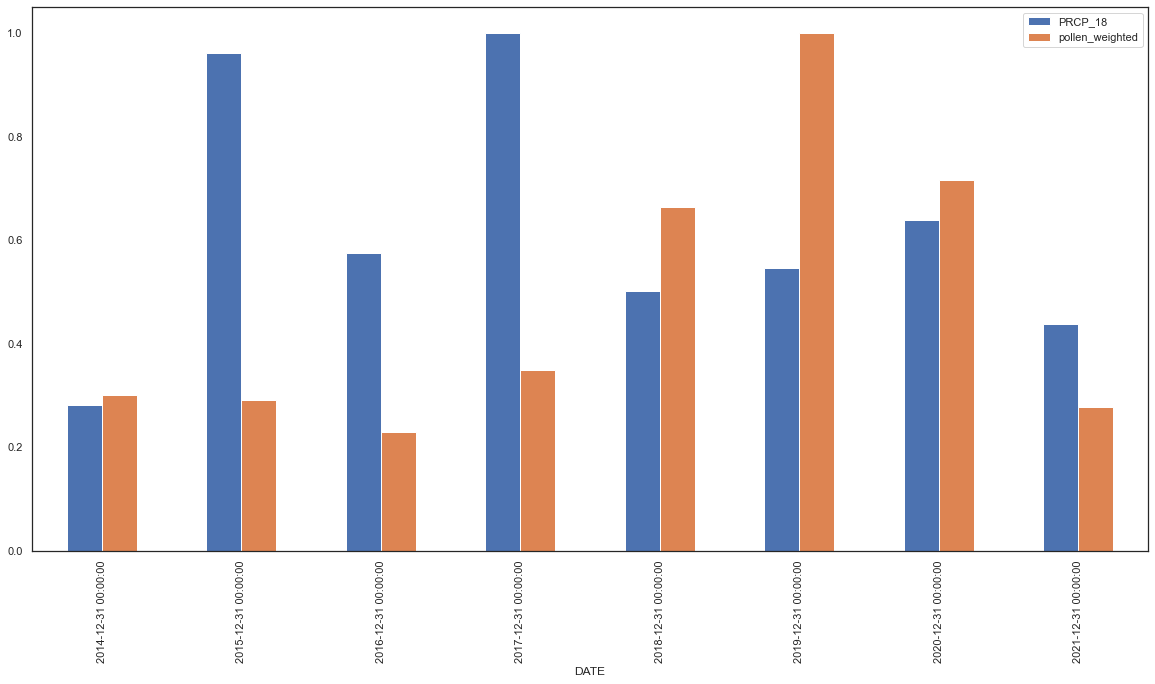

In [177]:
year_groups_scaled[['PRCP_18','pollen_weighted']]['2014':'2021'].plot(kind='bar')

<AxesSubplot:xlabel='DATE'>

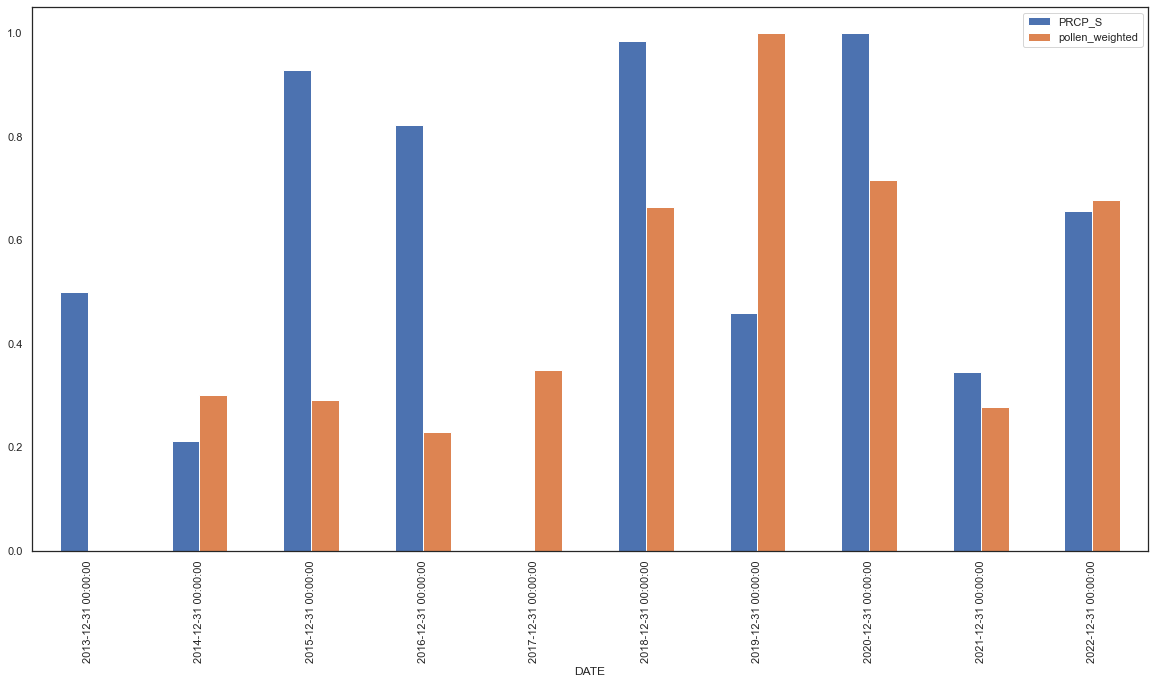

In [171]:
year_groups_scaled[['PRCP_S','pollen_weighted']].plot(kind='bar')

<AxesSubplot:xlabel='DATE'>

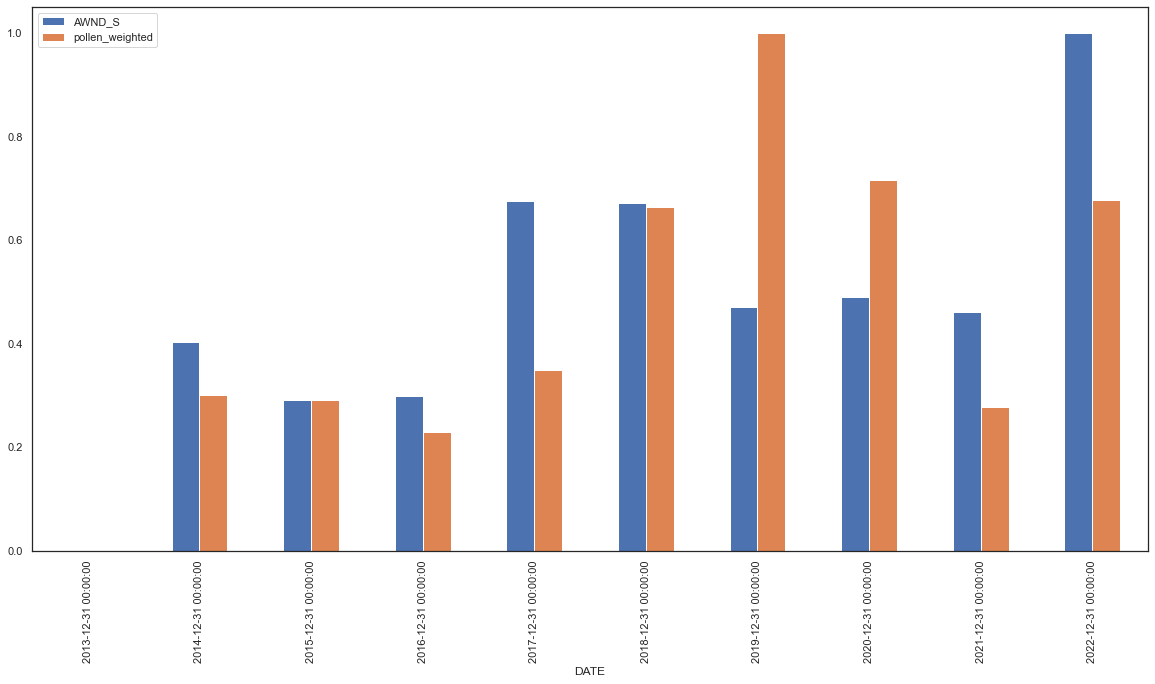

In [176]:
year_groups_scaled[['AWND_S','pollen_weighted']].plot(kind='bar')

Now before modeling the dataframe needs to be further cleaned.  the first 3 months of 2013 are missing for the weather data from Houston, then completing the datetime index, lastly imputing any missing values that arise from the previous step.

In [40]:
#first dropping the first 3 months of 2013, then ensuring a full datetime index, then imputing missing values
main_df = main_df.dropna(subset=['PRCP_18']).asfreq('D').interpolate()

In [41]:
# correcting the targets after the interpolation
for lvl in ['high', 'very_high', 'super_high']:
    main_df[lvl] = round(main_df[lvl])

<ipython-input-124-0e49b502fea1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist')
<ipython-input-124-0e49b502fea1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist')
<ipython-input-124-0e49b502fea1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist')
<ipython-input-124-0e49b502fea1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist')
<ipython-input-124-0e49b502fea1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist')
<ipython-input-124-0e49b502fea1>:3: UserWarning: Boolean Series key will be

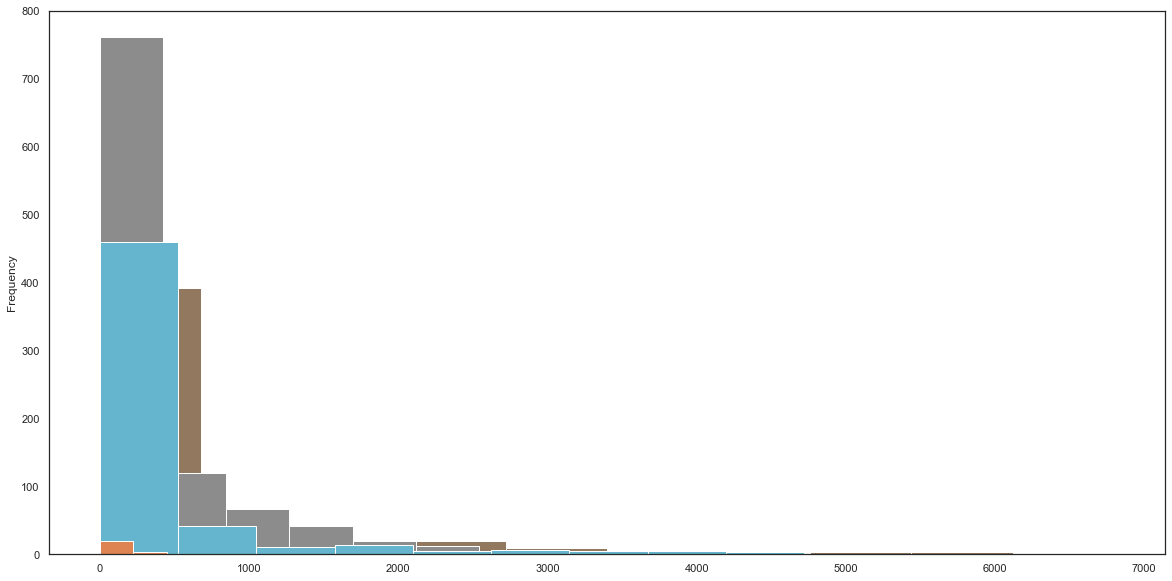

In [124]:
for tech in set(master_df['Tech.'].values):
    if tech != 'off':
        main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist')

In [43]:
main_df.drop('Tech.', axis=1, inplace=True)

<AxesSubplot:>

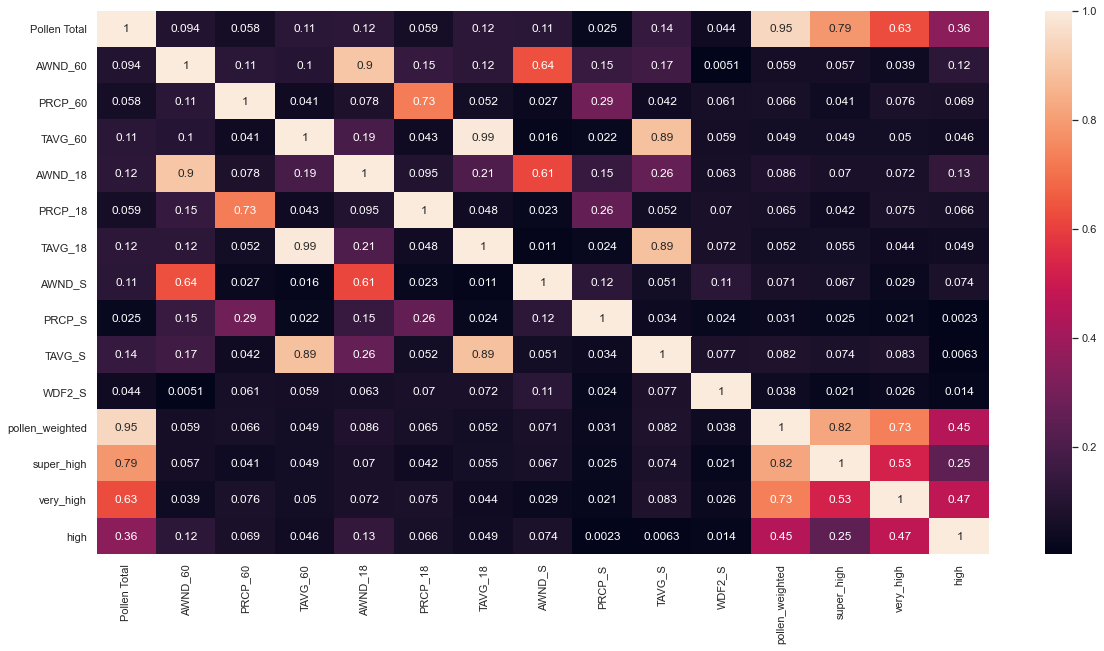

In [115]:
sns.set(rc = {'figure.figsize': (20,10)}, style='white')
sns.heatmap(main_df.corr().abs(), annot=True)

<AxesSubplot:>

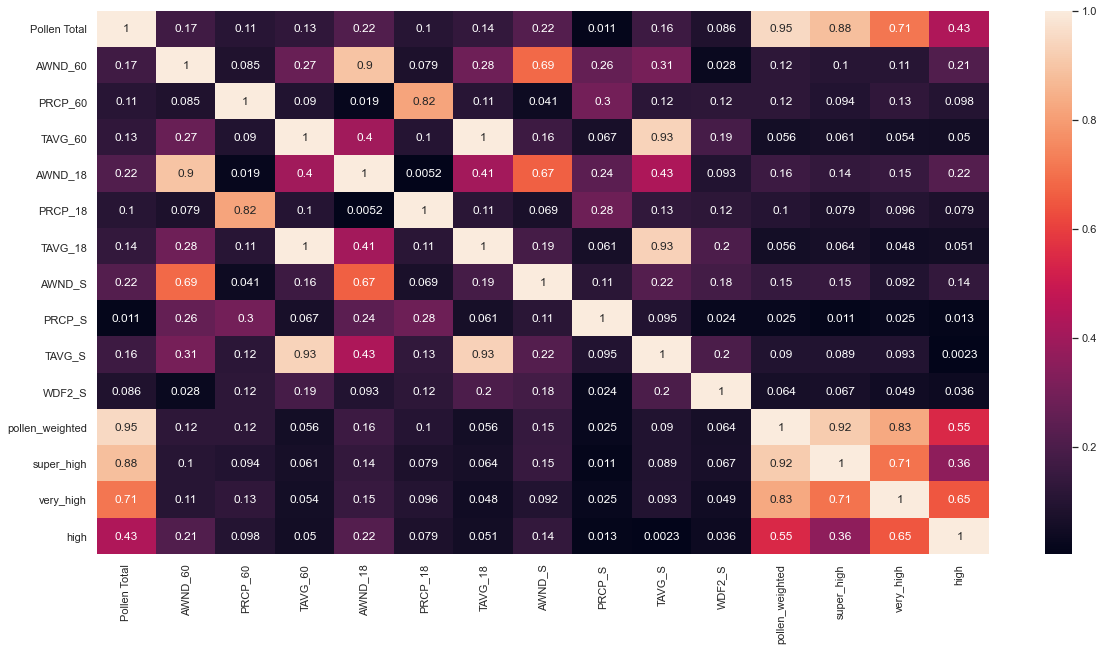

In [45]:
sns.heatmap(main_df.resample('W').mean().corr().abs(), annot=True)

# 5) Modeling With and Without Seasonality
The modeling portion of this report consists of two parts: Pollen Level Classification and Time Series Forecasting. Given that all of the variables appear to have seasonality. The correlations shown so far are likely merely a consequence of that. Modeling seasonal pollen levels from seasonal variables should be straightforward to address

The next question this report first hopes to address is if, with all trends removed, can a classification model such as logistic regression with these variables outperform a dummy classifier. 

The next question, much simpler, relies on this seasonality to forecast pollen levels reliably for Houston. While this is not a classifiction model, the predicted pollen counts are the basis for the classification targets and thus can be applied directly. 

The forecasting could then be applied to the further considerations, where, as proof of concept, artificial customers and medication purchases are generated to show how species data can be used as a diagnostic tool for allergen identification.

## 5a) Modeling with seasonality

In [195]:
# preparing the train/test split for logistic regression
X = main_df.drop(columns=['Pollen Total', 'pollen_weighted', 'super_high', 'very_high', 'high'])
y= main_df['high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

In [196]:
ss_s = StandardScaler()

X_train_scaled = ss_s.fit_transform(X_train)
X_test_scaled = ss_s.transform(X_test)

### Dummy Classifier
A dummy classifier that always returns the majority class was chosen as a baseline model

In [197]:
#showing the class breakdown of our data in percentage a 1.0 indicates a 'high' pollen data
y_test.value_counts(normalize=True)

1.0    0.512158
0.0    0.487842
Name: high, dtype: float64

In [198]:
baseline_model_s = DummyClassifier(strategy='most_frequent')
baseline_model_s.fit(X_train_scaled, y_train)
print('Accuracy:', baseline_model_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, baseline_model_s.predict(X_test_scaled)))

Accuracy: 0.5121580547112462 Precision: 0.5121580547112462


51% of the days in our test data are `high` pollen days so that is the best the dummy model can do. We next try logistic regression:

## First Logistic Regression for data with seasonality

In [199]:
lr1_s = LogisticRegression(random_state=85)
lr1_s.fit(X_train_scaled, y_train)
print('Accuracy:', lr1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, lr1_s.predict(X_test_scaled)))

Accuracy: 0.5759878419452887 Precision: 0.5697115384615384


This outperforms the baseline, barely. There is high multicolinearity in this data so it makes more sense to use a decision tree or random forest classifier

## First Decision Tree Classifier with seasonality

In [202]:
dt1_s = DecisionTreeClassifier(random_state=85)
dt1_s.fit(X_train_scaled, y_train)
print('Accuracy:', dt1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, dt1_s.predict(X_test_scaled)))

Accuracy: 0.5759878419452887 Precision: 0.5814606741573034


This decision tree matches the logistic regression in accuracy and onlt slightly outperforms in its precision. The next step is to see if tweaking paramaters improves it even more 
## Second Desicion Tree with Seaonality
To start we'll tweak one parameter `max_depth` to see if that improves it at all

In [213]:
dt2_s = DecisionTreeClassifier(random_state=85, max_depth=6)
dt2_s.fit(X_train_scaled, y_train)
print('Accuracy:', dt2_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, dt2_s.predict(X_test_scaled)))

Accuracy: 0.6367781155015197 Precision: 0.6324324324324324


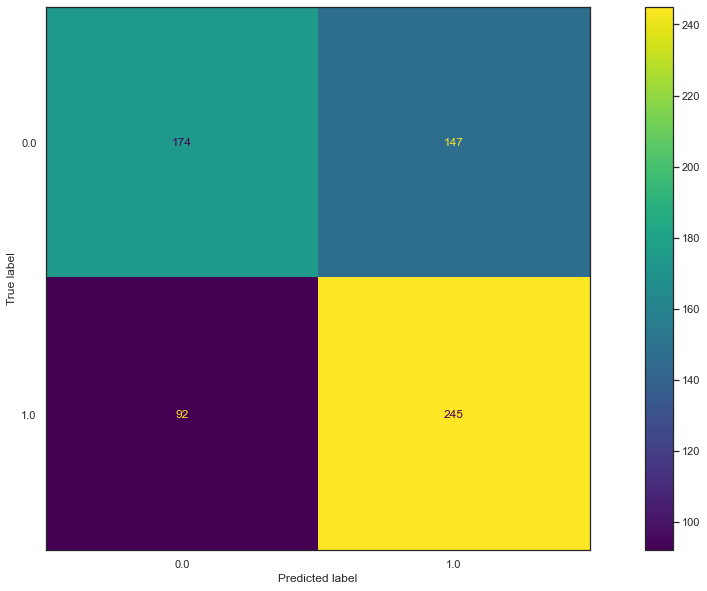

In [212]:
plot_confusion_matrix(dt2_s, X_test_scaled, y_test)

Modest improvement in both metrics here so it's followed up with a grid search of paramaters to see if it can produce even more accurate results
### Grid Search for decision tree parameters

In [ ]:
#The parameters to be iterated over in decision tree models
    param_grid_dt_s = {
      'n_estimators':[50, 100, 500],
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1, 5, 10, 50, 100]
 }
    
gridsearch_dt_s= GridSearchCV(estimator=DecisionTreeClassifier(random_state=85),
                  param_grid=param_grid,
                  cv=10,
                  )

grid_results_dt_s = gridsearch_dt_s.fit(X_train_scaled, y_train)

In [ ]:
#shows the parameters discovered by the grid search to optimize the model
grid_results_dt_s.best_params

These parameters are applied to a new model
## Grid Search Decision Tree with Seasonality

In [ ]:
grid_dt_s = DecisionTreeClassifier(random_state=85)

grid_dt_s.fit(X_train_scaled, y_train)
print('Accuracy:', dt2_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, dt2_s.predict(X_test_scaled)))

model performance:
grid search does not always produce the best results, but can offer a hint at where to make changes which will happen for the final Decision Tree model
## Final Decision Tree Model with Seaonality


In [ ]:
final_dt_s = DecisionTreeClassifier(random_state=85, )

final_dt_s.fit(X_train_scaled, y_train)
print('Accuracy:', final_dt_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, final_dt_s.predict(X_test_scaled)))

This has the best performace so far on both precision and accuracy. Given the success of a single decision tree, the next models will be random forest classifiers
## First Random Forest Classifer with Seasonality

In [214]:
rfc1_s = RandomForestClassifier(random_state=85)

rfc1_s.fit(X_train_scaled, y_train)
print('Accuracy:', rfc1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, rfc1_s.predict(X_test_scaled)))

Accuracy: 0.6413373860182371 Precision: 0.6383561643835617


This first Random Forest already outperforms our early Decision Trees on both accuracy and precision. Again the next step is to try tweaking parameters starting with `max_depth` as before 
## Second Random Forest Classifier with Seaonality

In [225]:
rfc2_s = RandomForestClassifier(random_state=85, max_depth=5)

rfc2_s.fit(X_train_scaled, y_train)
print('Accuracy:', rfc2_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, rfc2_s.predict(X_test_scaled)))

Accuracy: 0.6534954407294833 Precision: 0.639386189258312


Again improvement is seen, so it makes sense to proceed as before with a grid search
### Grid Search for Random Forest Classifier


In [ ]:
#The parameters to be iterated over in decision tree models
    param_grid_rfc_s = {
      'n_estimators':[50, 100, 500],
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1, 5, 10, 50, 100]
 }
    
gridsearch_rfc_s= GridSearchCV(estimator=RandomForestClassifier(random_state=85),
                  param_grid=param_grid,
                  cv=10,
                  )

grid_results_rfc_s = gridsearch_rfc_s.fit(X_train_scaled, y_train)

In [ ]:
#returns best parameters for the Random Forest
grid_result_rfc_s.best_params_

Taking these parameters identified by the grid search to use on our next Random Forest
## Grid Search Random Forest Classifier with Seasonality

In [ ]:
grid_rfc_s = RandomForestClassifier(random_state=85, max_depth=5)

grid_rfc_s.fit(X_train_scaled, y_train)
print('Accuracy:', grid_rfc_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, grid_rfc_s.predict(X_test_scaled)))

Again we see if tweaking these parameters manually can improve the model further
## Final Random Forest Classifier with Seasonality

In [233]:
final_rfc_s = RandomForestClassifier(random_state=85, max_depth=6)

final_rfc_s.fit(X_train_scaled, y_train)
print('Accuracy:', final_rfc_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, final_rfc_s.predict(X_test_scaled)))

Accuracy: 0.6534954407294833 Precision: 0.6445623342175066


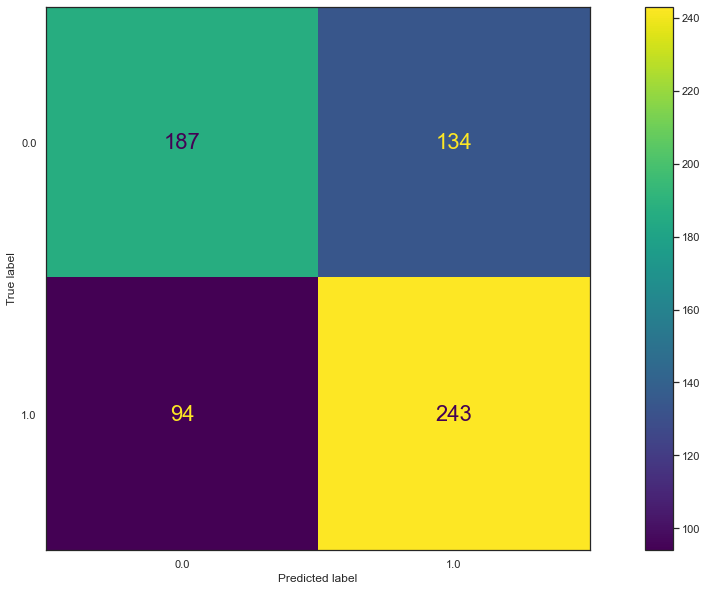

In [235]:
#confusion matrix for final RFC 
plot_confusion_matrix(final_rfc_s, X_test_scaled, y_test);

The best classification model for seasonal pollen is the Random Forest Classifier. Again all these data fluctuate seasonally, so we next try to tackle the question of, do these climate variables still have any predictive power when seasonality is taken out.
# 5b) Modeling Without Seasonality
in order to separate the seasonal component from the data, we try seasonal decomposition and isolate the residuals

### Seasonal Decomposition
given the high seasonlity of both target and variables, the first step is to remove that dependence from the data.

In [46]:
#uses stats models' seasonal_decompose to break the data into its trend and seasonal components
decomp_pollen = seasonal_decompose(main_df['pollen_weighted'].resample('D').mean(), extrapolate_trend='freq', period=365)

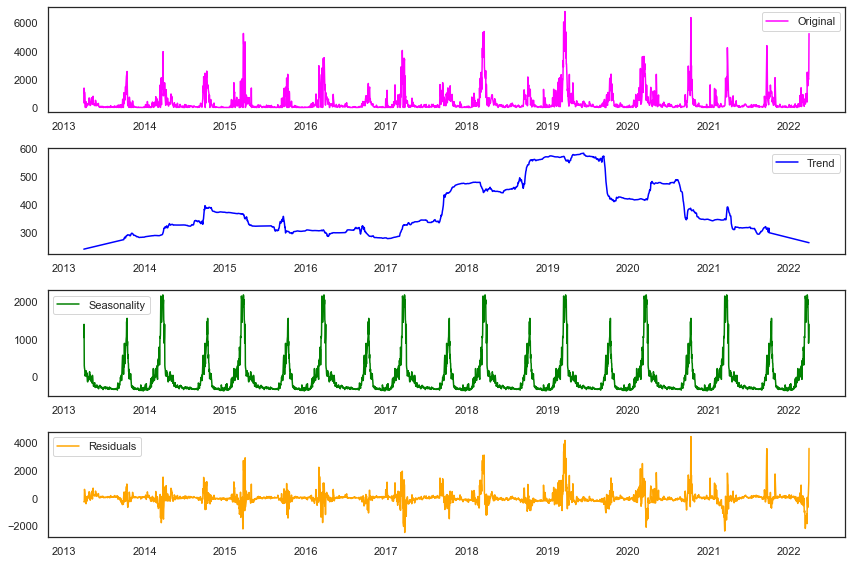

In [134]:
#isolating the decomposed elements
trend = decomp_pollen.trend
seasonal = decomp_pollen.seasonal
residual = decomp_pollen.resid

# plotting the decomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(main_df['pollen_weighted'], label='Original', color='magenta')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='orange')
plt.legend(loc='best')
plt.tight_layout()

The above shows the break down of our decomposed `pollen_weighted` data. To the eye it still looks as if there are seasonal fluctuations in the residuals, but this worked better than differencing (Appendix)

The point in this section is to remove the seasonal component from all elements in the dataframe. This is performed below where a dataframe of only the decomposed residuals of all columns into a new dataframe

In [49]:
# applying the seasonal_decompose function to all columns and reforming it into a new dataframe
df_resid = main_df.resample('D').mean().apply(lambda x: seasonal_decompose(x, extrapolate_trend='freq').resid)
df_trend = main_df.resample('D').mean().apply(lambda x: seasonal_decompose(x, extrapolate_trend='freq').trend)
df_resid_trend = df_resid+df_trend
df_resid_trend.head()

,Pollen Total,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
DATE,,,,,,,,,,,,,,,
2013-04-01,1048.514526,5.914885,-0.008414,66.933203,5.667954,-0.032124,66.984706,2.386748,0.007795,62.922404,166.624599,1048.726374,0.002916,1.017801,1.049086
2013-04-02,1338.693762,9.761012,1.477976,66.697510,9.833483,1.541333,67.726076,6.978422,0.146503,60.199168,31.521255,1376.210161,-0.000329,1.000715,0.970265
2013-04-03,262.162264,10.361799,0.186130,62.853329,12.158925,0.130491,63.810673,8.355177,0.151698,44.858693,44.367760,274.709630,-0.012520,-0.001565,0.997827
2013-04-04,1052.126115,10.916316,0.011303,53.084017,12.678216,0.033528,54.034240,6.287265,-0.019696,44.146226,313.112875,1068.899805,-0.016200,0.987970,0.972295
2013-04-05,898.697720,4.486033,0.013859,56.236680,5.552705,0.034395,57.214809,1.231493,0.010017,53.150191,40.088155,947.287547,0.002010,0.996126,1.014880


In [50]:
#resetting the target columns back to original values which were also decomposed above
df_resid = df_resid.drop(columns=['super_high', 'very_high', 'high'])
df_resid_trend = df_resid_trend.drop(columns=['super_high', 'very_high', 'high'])
target_df=main_df[['super_high','very_high','high']]

In [236]:
#checking that our target has been restored
target_df['high'].value_counts(normalize=True)

1.0    0.522969
0.0    0.477031
Name: high, dtype: float64

In [52]:
#reforming the data frame with residual variables and original targets
model_resid = pd.concat([df_resid,target_df], axis=1)
model_wtrend = pd.concat([df_resid_trend,target_df], axis=1)

First it makes sense to see if there are any correlations in the data with seasonality purportedly removed

<AxesSubplot:>

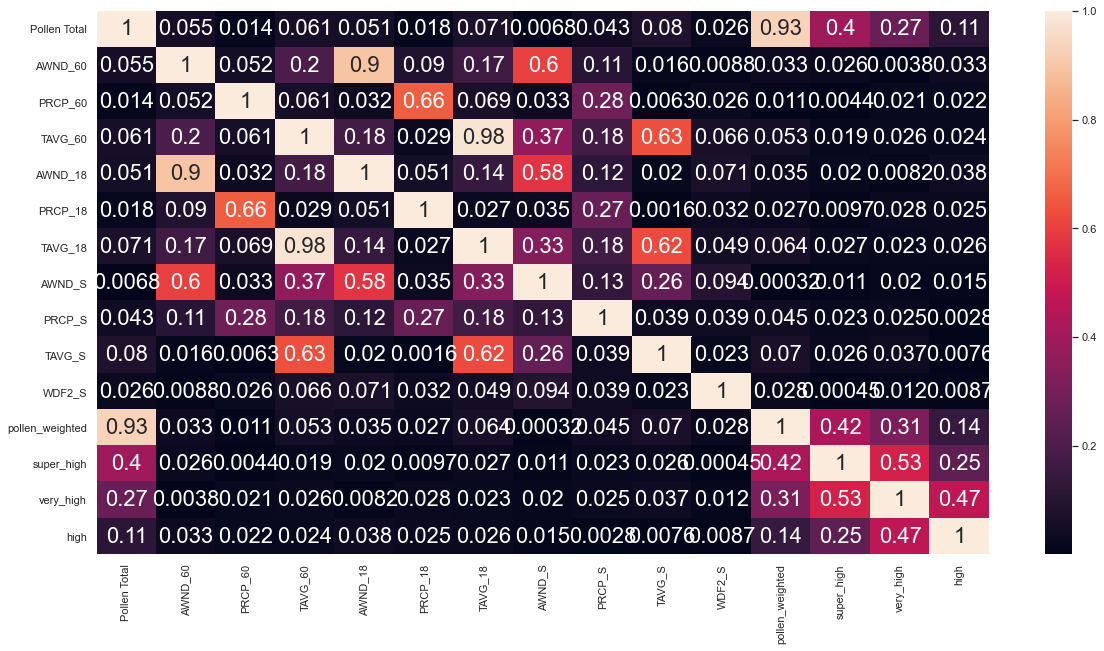

In [246]:
#correlation heatmap
sns.heatmap(model_resid.corr().abs(), annot=True)

having removed seasonality, it is evident that there are now no exceptionally strong correlations between pollen levels and the weather realted variables. Nonetheless, the point of this report is to provide a classification model

In [367]:
# preparing the train/test split for logistic regression
X_r = model_resid.drop(columns=['Pollen Total', 'pollen_weighted', 'super_high', 'very_high', 'high'])
y_r= model_resid['high']

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.2, random_state=85)

## Baseline Dummy Classifier without Seasonality*
A dummy classifier that chooses the majority class is used as the baseline model

In [368]:
baseline_model = DummyClassifier(random_state=85, strategy='most_frequent')

baseline_model.fit(X_r_train,y_r_train)

DummyClassifier(random_state=85, strategy='most_frequent')

In [369]:
print('Accuracy:', baseline_model.score(X_r_test, y_r_test), 
      ', Precision:', precision_score(y_test, baseline_model.predict(X_r_test)))

Accuracy: 0.5121580547112462 , Precision: 0.5121580547112462


51% accurate, just as expected

## First Logistic Regression without seasonality
first employed will be a standard logistic regression model without the bells and whistles. Data will be scaled.

In [370]:
ss = StandardScaler()

X_r_train_sc = ss.fit_transform(X_r_train)
X_r_test_sc = ss.transform(X_r_test)

In [371]:
lr1 = LogisticRegression(random_state=85)

lr1.fit(X_r_train_sc, y_r_train)
print('Accuracy:', lr1.score(X_r_test_sc, y_r_test), ', Precision:', precision_score(y_r_test, lr1.predict(X_r_test_sc)))

Accuracy: 0.5106382978723404 , Precision: 0.5136116152450091


The logisitic regression perform even worse than  dummy classifier! Yet again, due to the high multiconlinearity that violate assumptions for this type of model, it makes sense to switch gears and move on to another machine learning model that be more appropriate and accurate

## First Decision Tree
The next model tried is decision tree model with a max depth of 4. This depth was chosen after a few attempts of minor manipulation. 

In [372]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt1 = DecisionTreeClassifier(max_depth=4)
dt1.fit(X_r_train_sc, y_r_train)
print('Accuracy:', dt1.score(X_r_test_sc, y_r_test), ', Precision:', precision_score(y_test, dt1.predict(X_test_sc)))

Accuracy: 0.5547112462006079 , Precision: 0.5654761904761905


With 55% accuracy, the decision tree has successfully outperformed the dummy, but only just. It hints that there may be a slightly more than random relationship between the chosen variables and airborne pollen levels. The confusion matrix shows the breakdown of false/true positives and negatives:

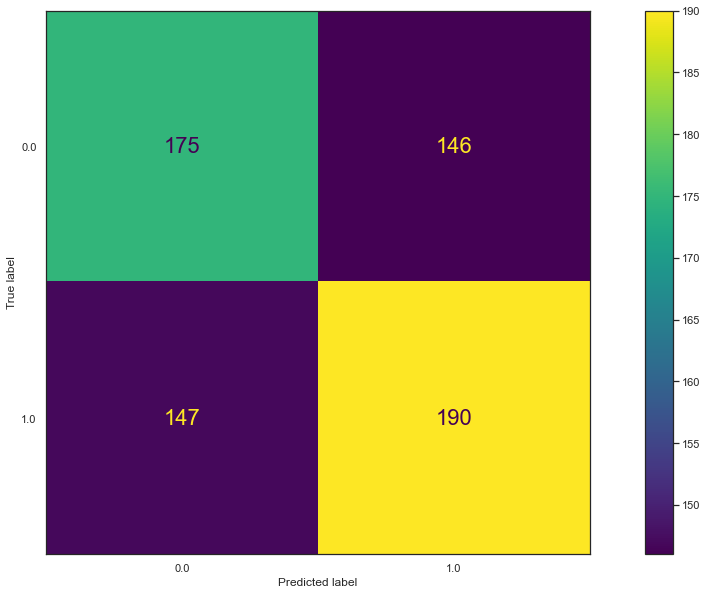

In [336]:
plot_confusion_matrix(dt1, X_r_test_sc, y_r_test)

To see which features were identified as important by this decision tree its dendrogram is visualized below

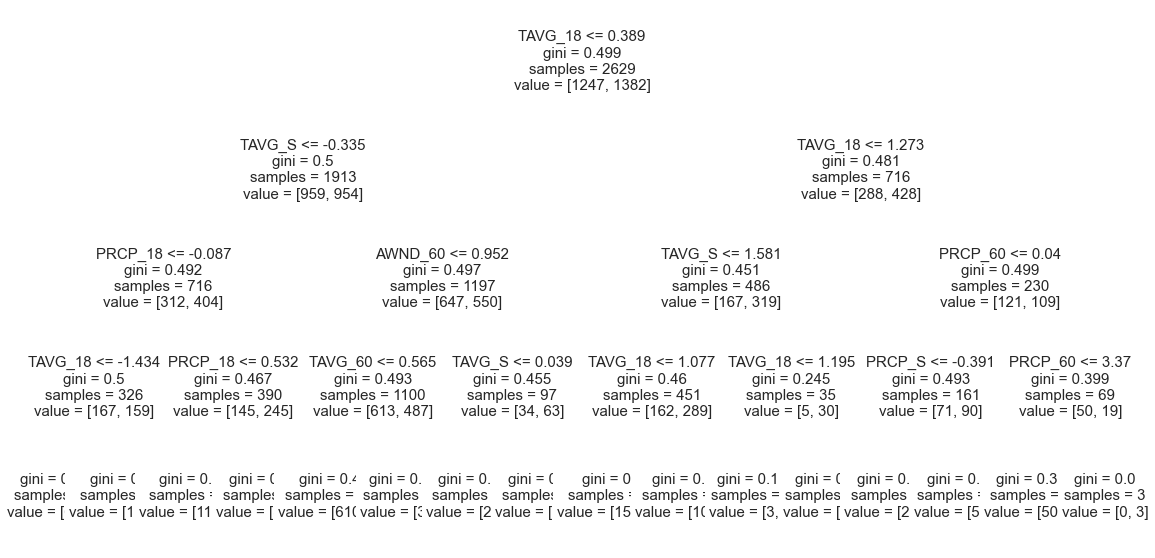

In [337]:
plot_tree(dt1, fontsize=15, feature_names=X.columns);

Somewhat surprisingly, this decision tree has decided that the average temperature in Houston `TAVG_18` is the most important factor followed by average temperature in Shreveport, LA `TAVG_S` in making splits. . 

This relationship with temperature may only be a relic of seasonality. However it also may point to other phenomena such as the effect of temperature on air pressure and air currents and convection effects that lift pollen towards the upper atmosphere. Houston wind speed and precipitation were the next most important features according to this particular model. It is prudent to explore the parameters a decision tree model in order to maximize accuracy, yet given the relative success of the single decision tree, it bears to reason that multiple decision trees might perform even better, as it did in section 5a.

## First Random Forest Classifier without seasonality*

In [373]:
rfc1 = RandomForestClassifier(random_state=85)
rfc1.fit(X_r_train_sc, y_r_train)
print('Accuracy:', rfc1.score(X_r_test_sc, y_test), ', Precision:', precision_score(y_r_test, rfc1.predict(X_r_test_sc)))

Accuracy: 0.5851063829787234 , Precision: 0.5820512820512821


Assumptions were correct and the Random Forest is the best classifier so far in terms of accuracy, *59%* and precision, *58%* for decomposed residuals. The second attempt, keeping in fashion with the rest of the models, will make a tweak to the `max_depth` parameter.

## Second Random Forest Classifier without seasonality*

In [374]:
rfc2 = RandomForestClassifier(random_state=85, max_depth=5)
rfc2.fit(X_r_train_sc, y_r_train)
print('Accuracy:', rfc2.score(X_r_test_sc, y_test), ', Precision:', precision_score(y_r_test, rfc2.predict(X_r_test_sc)))

Accuracy: 0.5653495440729484 , Precision: 0.5645569620253165


This performs worse than the first Random Forst which had default hyperparameters in place. The next logical step is to do a grid search to find parameters that yield the best RFC for this decomposed data.

In [84]:
 param_grid_rfc = {
      'n_estimators':[50, 100, 500],
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1, 5, 10, 50, 100]
 }
    
gridsearch= GridSearchCV(estimator=RandomForestClassifier(random_state=85),
                  param_grid=param_grid_rfc,
                  cv=10,
                  )

grid_results = gridsearch.fit(X_r_train_sc, y_r_train)

In [85]:
#outputs best parameters acc to grid search above
gridsearch.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 50,
 'n_estimators': 100}

the grid search has provided the best paramaters (shown above) for the random forest classifier and will be implemented in the final model below
## Grid Search Random Forest Classifier without seasonality*

In [375]:
grid_rfc = RandomForestClassifier(random_state=85, criterion = 'gini', max_depth=4, min_samples_leaf=50, n_estimators=100)

grid_rfc.fit(X_r_train_sc, y_r_train)
print('Accuracy:', grid_rfc.score(X_r_test_sc, y_test), 
      ', Precision:', precision_score(y_r_test, grid_rfc.predict(X_r_test_sc)))

Accuracy: 0.5638297872340425 , Precision: 0.5603864734299517


This actually does worse in terms of accuracy. The first model with default parameters did best. Tweaking the default parameters slightly by hand results in the best model for this data.

## Final Random Forest Classifer without Seasonality*

In [376]:
rfc_final = RandomForestClassifier(random_state=85, criterion='gini', max_depth=100, min_samples_leaf=1, n_estimators=200)

rfc_final.fit(X_r_train_sc, y_r_train)
print('Accuracy:', rfc_final.score(X_r_test_sc, y_test), 
      ', Precision:', precision_score(y_r_test, rfc_final.predict(X_r_test_sc)))

Accuracy: 0.5987841945288754 , Precision: 0.5910224438902744


with 60% accuracy and 60% precision this is the best classification model for the decomposed residuals. Is it possible to conclude that daily climate conditions have *some* influence over pollen levels regardless of seasonality? Probably not for sure. If one takes a closer look at the original residuals, and the climate data in the residuals dataframe, it's hard not see that some seasonality remains despite what the `seasonal_decompose` function accomplished.

<AxesSubplot:xlabel='DATE'>

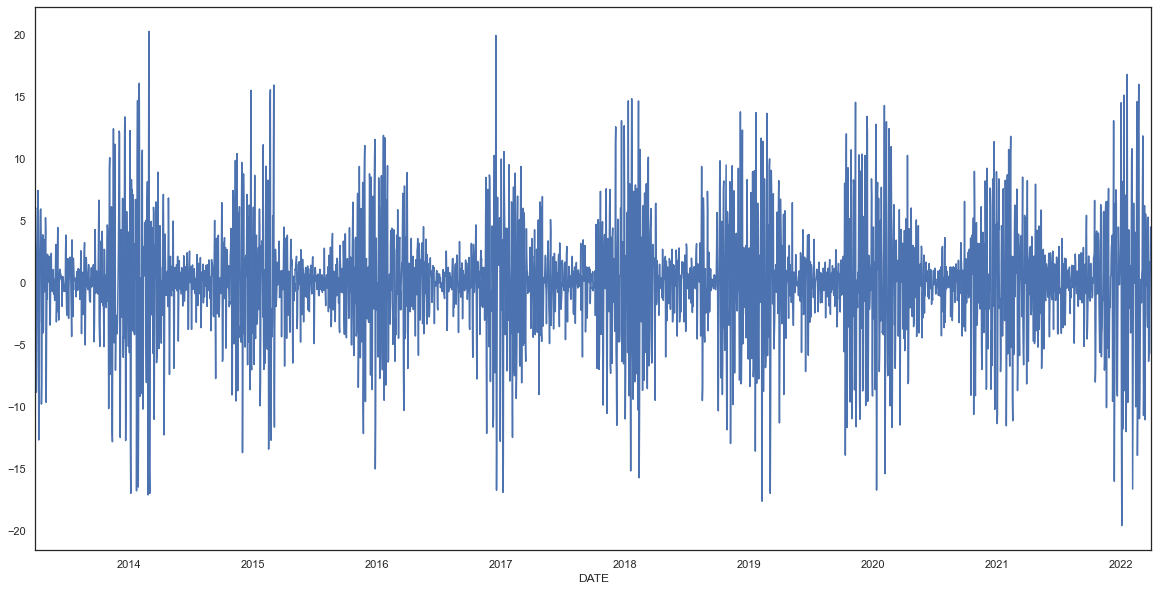

In [377]:
model_resid['TAVG_18'].plot()

clearly seasonality wasn't removed from the data so much as muffled a bit, which makes sense given that all the models with seasonality outperformed their counterparts in this section. Thus the question still remains. 

Interestingly enough, when decomposing an upsampled weekly data, the `seasonal_decompose` function appears to successfully remove all seasonality from the residuals as demonstrated in the following section

# 5c) Exploring Weekly Data

As mentioned above the upsampled weekly data appears fully decomposed yielding a much more 'white-noise'-esque picture:
### Seasonal Decomposition of Weekly Averages

In [404]:
#uses stats models' seasonal_decompose to break the data into its trend and seasonal components
decomp_pollen_weekly = seasonal_decompose(main_df['pollen_weighted'].resample('W').mean(), extrapolate_trend='freq',
                                         period=52)

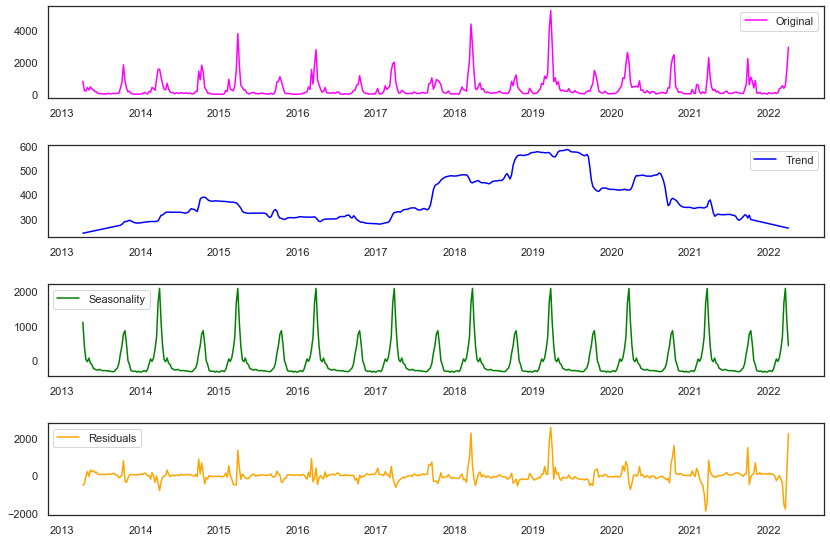

In [405]:
### isolating the decomposed elements
trend_w = decomp_pollen_weekly.trend
seasonal_w = decomp_pollen_weekly.seasonal
residual_w = decomp_pollen_weekly.resid

# plotting the decomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(main_df['pollen_weighted'].resample('W').mean(), label='Original', color='magenta')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_w, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_w,label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_w, label='Residuals', color='orange')
plt.legend(loc='best')
plt.tight_layout()

There are many advantages of using weekly data, as it gives a better picture of the whole week. the major disadvantage in this case, however, is the limited number of observations is yields, roughly 500. This is usually not enough for modeling. This concept is further explored in the appendix

Perhaps more important for consumers than classification is forecasting with time series models. 
# 6 Pollen Forecasting and Time Series Modeling
refering back to 

In [491]:
log_df = main_df.copy()
log_df['log_pollen'] = np.log(log_df['pollen_weighted'])
log_df[log_df['log_pollen'] == log_df['log_pollen'].min()] = np.nan
log_df['log_pollen'].interpolate(method='time', inplace=True)

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='DATE'>

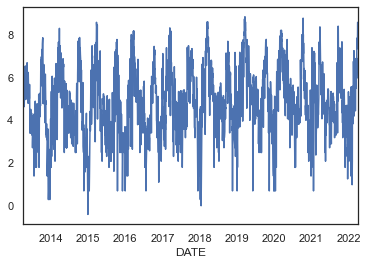

In [493]:
log_df['log_pollen'].plot()

In [495]:
split_cutoff = round(len(log_df)*0.8)

Train = log_df[:split_cutoff]
Test = log_df[split_cutoff:]

In [492]:
adfuller(log_df['log_pollen'])

(-6.812111207390824,
 2.10343220542623e-09,
 8,
 3278,
 {'1%': -3.4323464698589774,
  '5%': -2.8624221218326817,
  '10%': -2.5672395719722254},
 7477.192052694753)

In [415]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2013-04-01 to 2022-03-31
Freq: D
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pollen Total     3287 non-null   float64
 1   AWND_60          3287 non-null   float64
 2   PRCP_60          3287 non-null   float64
 3   TAVG_60          3287 non-null   float64
 4   AWND_18          3287 non-null   float64
 5   PRCP_18          3287 non-null   float64
 6   TAVG_18          3287 non-null   float64
 7   AWND_S           3287 non-null   float64
 8   PRCP_S           3287 non-null   float64
 9   TAVG_S           3287 non-null   float64
 10  WDF2_S           3287 non-null   float64
 11  pollen_weighted  3287 non-null   float64
 12  super_high       3287 non-null   float64
 13  very_high        3287 non-null   float64
 14  high             3287 non-null   float64
 15  log_pollen       3287 non-null   float64
dtypes: float64(16)
memory usage: 436.6

In [496]:
params_daily = []
for combo in pdq:
    for combos in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX((Train['log_pollen']),
                                            order=combo,
                                            seasonal_order=combos,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            params_daily.append([combo, combos, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combo, combos, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =16005.044160252772
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =13401.786522125843
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =9377.371554236295
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =9202.319657422468
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =9324.819348340036
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =9208.915425775363
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =9225.003683237537
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =8822.91024706684
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =12987.48154048312
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =11146.763059006113
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =8268.264577797598
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7878.770553114978
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =8189.758054444614
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =7881.829550244302
ARIMA (0, 0, 1) x 

In [497]:
# Find the parameters with minimal AIC value
params_daily_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
params_daily_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 1, 1, 12)
aic           6684.47
Name: 43, dtype: object

In [477]:
log_df[log_df['log_pollen']==log_df['log_pollen'].min()] = np.nan

In [478]:
log_df['log_pollen'].min()

-0.40546510810816444

In [498]:
# Plug the optimal parameter values into a new SARIMAX model
Daily_Arima = sm.tsa.statespace.SARIMAX(Train['log_pollen'], 
                                        order=(1, 0, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = Daily_Arima.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         log_pollen   No. Observations:                 2630
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -3086.867
Date:                            Tue, 03 May 2022   AIC                           6181.735
Time:                                    18:52:01   BIC                           6205.194
Sample:                                04-01-2013   HQIC                          6190.234
                                     - 06-12-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9228      0.009    100.992      0.000       0.905       0.941
ma.L1         -0.2254      0.015    -15.318      0.000      -0.254      -0.197
ma.S.L12      -1.0000      1.496     -0.669      0.504      -3.931       1.931
sigma2         0.6134      0.919      0.667      0.505      -1.188       2.415
===================================================================================
Ljung-Box (L1) (Q):                   2.34   Jarque-Bera (JB):              1905.23
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.27
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

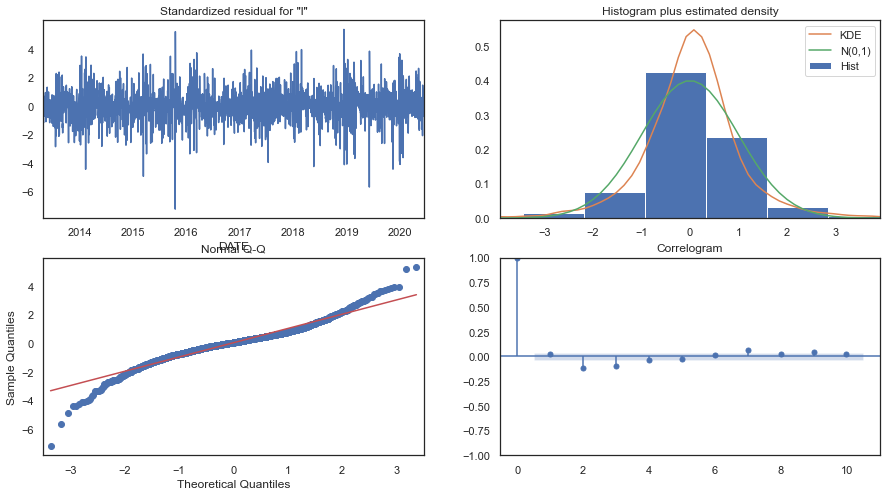

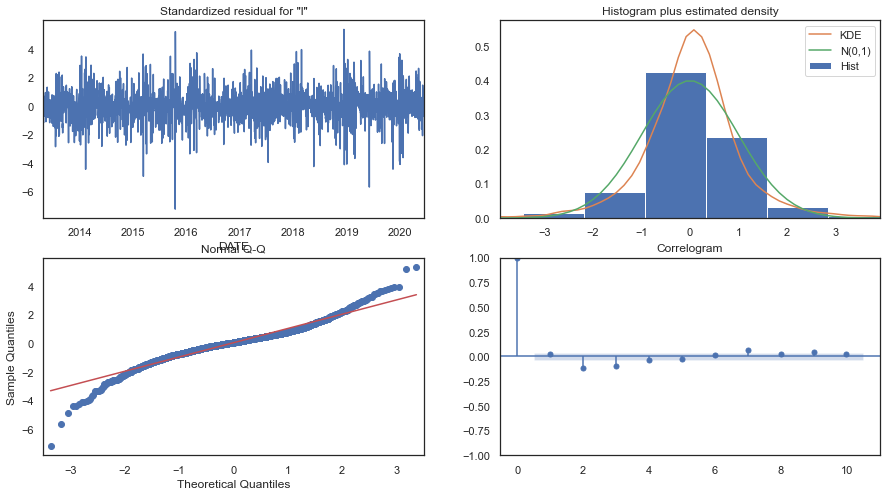

In [499]:
output.plot_diagnostics(figsize=(15,8))

In [505]:
log_df[split_cutoff:]

,Pollen Total,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high,log_pollen
DATE,,,,,,,,,,,,,,,,
2020-06-13,39.333333,7.61,0.00,81.0,9.62,0.00,84.0,4.03,0.00,80.0,30.0,193.0,0.0,0.0,1.0,5.262690
2020-06-14,34.666667,6.93,0.00,81.0,8.50,0.00,82.0,4.03,0.00,81.0,60.0,182.0,0.0,0.0,1.0,5.204007
2020-06-15,30.000000,8.05,0.00,82.0,8.28,0.00,85.0,4.03,0.00,83.0,150.0,171.0,0.0,0.0,1.0,5.141664
2020-06-16,28.000000,5.82,0.00,82.0,5.82,0.00,84.0,4.03,0.00,83.5,70.0,138.0,0.0,0.0,1.0,4.927254
2020-06-17,18.000000,5.59,0.00,83.0,6.04,0.00,83.0,4.70,0.00,81.0,90.0,90.0,0.0,0.0,0.0,4.499810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27,1742.666667,8.95,0.00,72.0,10.96,0.00,70.0,6.04,0.00,65.5,200.0,1871.0,1.0,1.0,1.0,7.534228
2022-03-28,1886.000000,8.95,0.00,72.0,12.08,0.00,71.0,8.50,0.00,67.5,180.0,2047.0,1.0,1.0,1.0,7.624131
2022-03-29,1866.000000,17.00,0.00,74.0,17.00,0.00,74.0,14.76,0.00,74.0,170.0,1990.0,1.0,1.0,1.0,7.595890


In [521]:
preds = output.get(type = 'levels',start=Train.index[0], end = Test.index[-1])

In [513]:
preds1 = output.predict()

<AxesSubplot:>

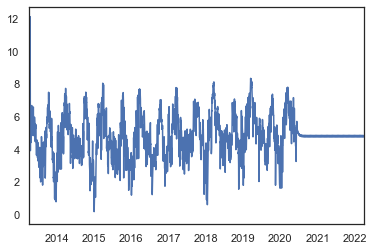

In [522]:
preds.plot()

In [430]:
#weekly
params_weekly = []
for combo in pdq:
    for combos in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX((main_df['pollen_weighted'].resample('W').mean()),
                                            order=combo,
                                            seasonal_order=combos,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([combo, combos, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combo, combos, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7530.668981556016
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7347.784205379083
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =7601.653596001577
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =7067.911020330263
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =7359.922685904947
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =7271.563428930687
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =7169.472951558654
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7051.838818650142
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7196.911638580224
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7023.558317574556
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =7295.3035555554
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6793.089626839723
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7051.510154971035
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6973.364362106156
ARIMA (0, 0, 1) x (1, 

In [431]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 1, 1, 12)
aic           6684.47
Name: 43, dtype: object

In [447]:
# Plug the optimal parameter values into a new SARIMAX model
weekly_arima = sm.tsa.statespace.SARIMAX(log_df['pollen_weighted'].resample('W').mean(), 
                                        order=(1, 0, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
weekly_results = weekly_arima.fit()
weekly_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    pollen_weighted   No. Observations:                  470
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -3338.236
Date:                            Sat, 30 Apr 2022   AIC                           6684.473
Time:                                    17:47:12   BIC                           6700.856
Sample:                                04-07-2013   HQIC                          6690.934
                                     - 04-03-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6389      0.028     22.455      0.000       0.583       0.695
ma.L1          0.2729      0.038      7.163      0.000       0.198       0.348
ma.S.L12      -1.0001      0.028    -35.223      0.000      -1.056      -0.944
sigma2      1.838e+05   1.54e-07   1.19e+12      0.000    1.84e+05    1.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2534.14
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             2.14
Prob(H) (two-sided):                  0.87   Kurtosis:                        13.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.56e+26. Standard errors may be unstable.
"""

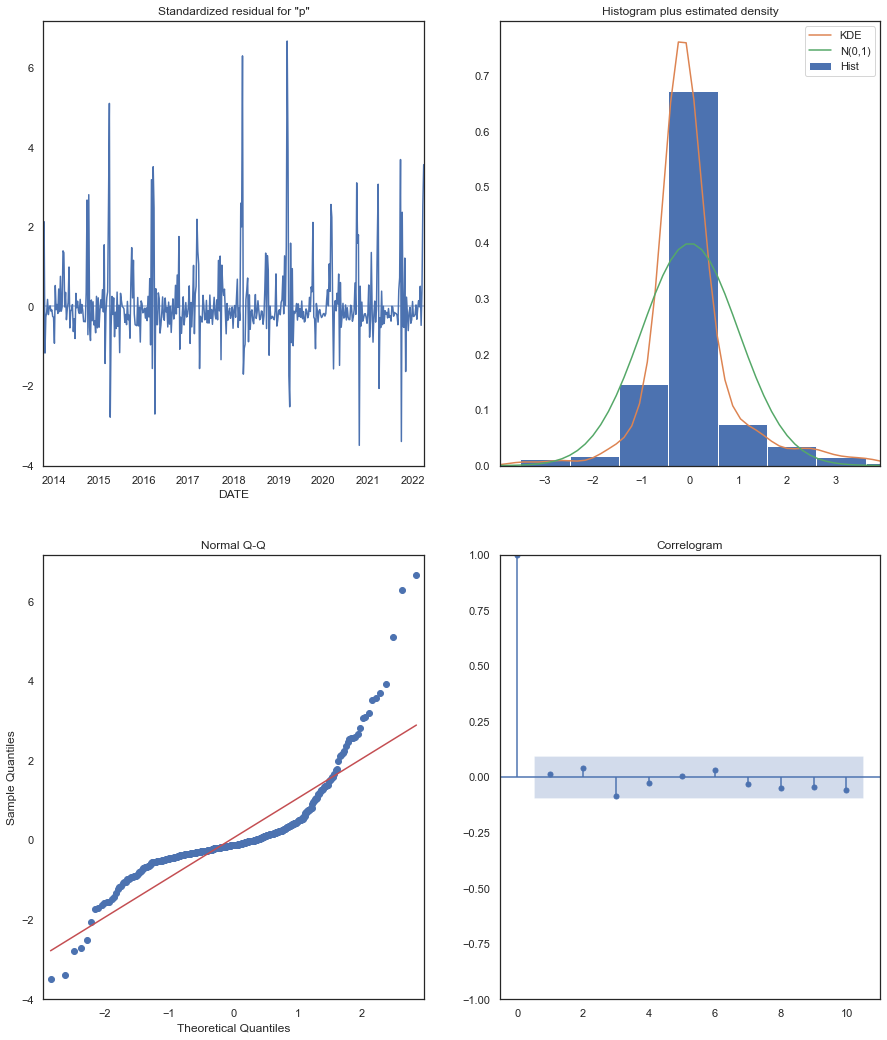

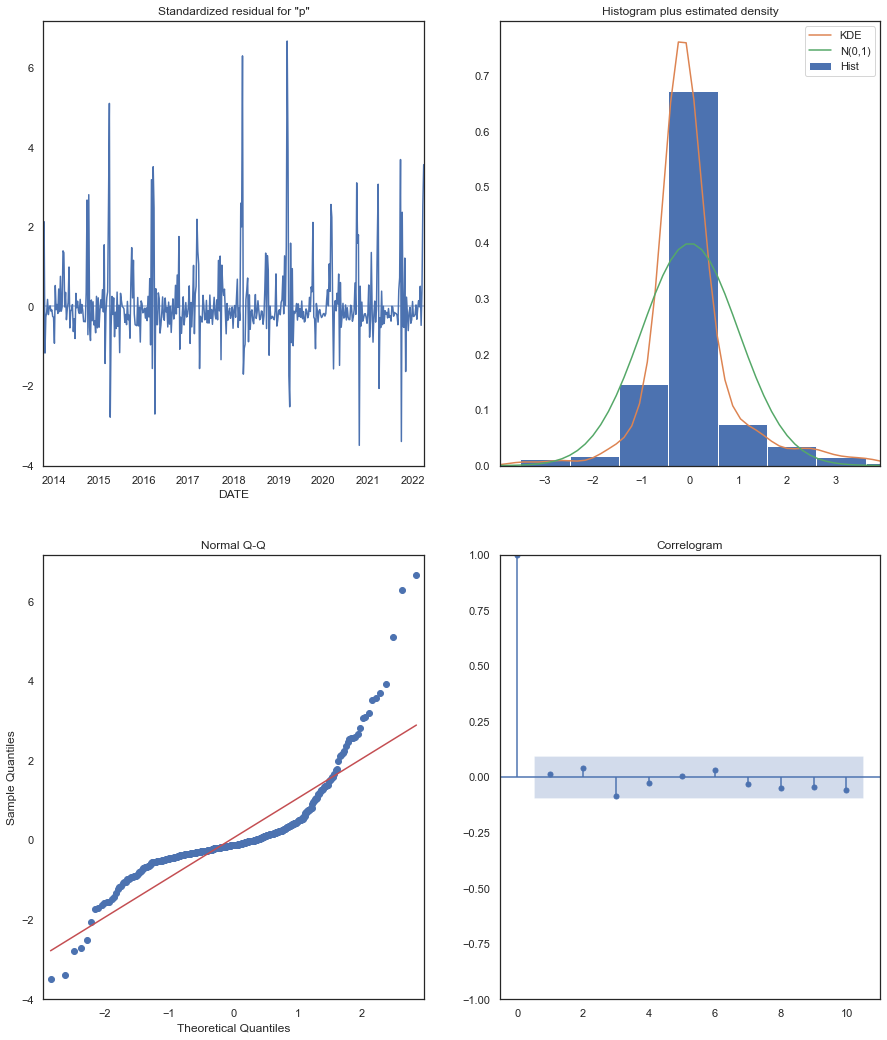

In [444]:
weekly_results.plot_diagnostics(figsize= (15,18))

# Further Considerations: Species Analysis
An Additional goal of this report, intended primarily for further research is a comprehensive breakdown of plant (and eventually mold) species. The goal being to work with pharmacies and customers to match days of purchase and usage of allergy medications to spikes in pollen counts. This could be used a diagnostic support tool for allergy-type identification.  More detailed, yet still preliminary work can be found <a href='www.google.com'>here</a> 

In [450]:
species_df = master_df[:16]
species_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2013-01-01 to 2013-01-16
Freq: D
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Alder                        0 non-null      float64
 1   Ash                          12 non-null     float64
 2   Ashe Juniper / Bald Cypress  12 non-null     float64
 3   Black Gum                    12 non-null     float64
 4   Black Walnut                 12 non-null     float64
 5   Bushes                       12 non-null     float64
 6   Birch                        12 non-null     float64
 7   Cedar                        0 non-null      float64
 8   Cotton Wood                  12 non-null     float64
 9   Dogwood                      12 non-null     float64
 10  Elm                          12 non-null     float64
 11  Glandular Mesquite           12 non-null     float64
 12   Hackberry                   12 non-null     float64

# Conclusion